In [1]:
import warnings

# 方法①: 全ての FutureWarning を無視（簡易）
warnings.simplefilter('ignore', FutureWarning)

# 方法②: モジュール／メッセージを限定して無視（より安全）
warnings.filterwarnings(
    'ignore',
    category=FutureWarning,
    module=r'seaborn\._oldcore',
    message=r'.*use_inf_as_na option is deprecated.*'
)

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
np.seterr(invalid='ignore')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

/kaggle/input/neurips-open-polymer-prediction-2025/sample_submission.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train.csv
/kaggle/input/neurips-open-polymer-prediction-2025/test.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset2.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset4.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset1.csv
/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset3.csv
/kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl


# For now, let's take a look at the training data.

In [2]:
# Tg:ガラス転移温度
# FFV:相対自由体積
# Tc:熱伝導率
# Density:密度
# Rg:回転半径
path="/kaggle/input/neurips-open-polymer-prediction-2025/"
train = pd.read_csv(path+"train.csv")
print("train data shape is : " , train.shape)
train.head(3)

train data shape is :  (7973, 7)


,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN


# What exactly is “SMILES”…?
It seems that with a library called "rdkit," we can easily extract features, but since it can't be installed directly via pip, I got it from the dataset and installed it.

In [3]:
import kagglehub
download_path = kagglehub.dataset_download("senkin13/rdkit-2025-3-3-cp311")
print("Path to dataset files", download_path)

Path to dataset files /kaggle/input/rdkit-2025-3-3-cp311


In [4]:
!pip install /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem,Lipinski, rdMolDescriptors
from rdkit.Chem import Draw
from IPython.display import display

Processing /kaggle/input/rdkit-2025-3-3-cp311/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl


# “SMILES” seems to look something like this.
Interesting how it can appear in different ways.

*CC(*)c1ccccc1C(=O)OCCCCCC  image is looks like below


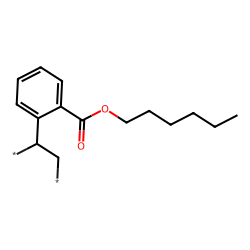

*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5ccc(N*)cc5)cc4)CCC(CCCCC)CC3)cc2)cc1  image is looks like below


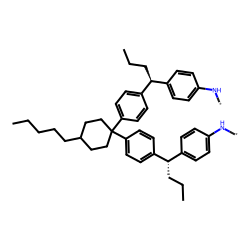

*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8ccc(C=C9CCCC(=Cc%10ccc(*)cc%10)C9=O)cc8)cc7)cc6)cc5)CCCCC4)cc3)cc2)cc1  image is looks like below


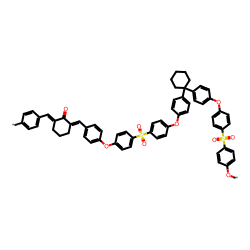

*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)c(-c3ccc(C)cc3)c2-c2ccc(C)cc2)cc1  image is looks like below


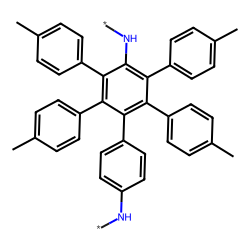

*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N+](=O)[O-])cc3)c(C(*)=O)cc2OCCCCCCCCCOCC2CCCN2c2ccc([N+](=O)[O-])cc2)cc1  image is looks like below


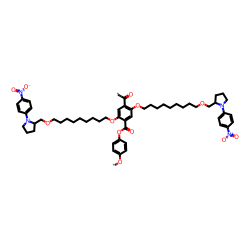

In [5]:
def calc_features(smiles: str) -> dict:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "origin":mol,
        "MolWt": Descriptors.MolWt(mol),
        "NumAromaticRings": Lipinski.NumAromaticRings(mol),
        "NumRings": rdMolDescriptors.CalcNumRings(mol),
        "FractionCSP3": Descriptors.FractionCSP3(mol),
        "NumRotatableBonds": Lipinski.NumRotatableBonds(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBA": Lipinski.NumHAcceptors(mol),
        "HBD": Lipinski.NumHDonors(mol),
        "BalabanJ": Descriptors.BalabanJ(mol),
        "MolLogP": Descriptors.MolLogP(mol),
    }
for i in range(5):
    smiles = train["SMILES"][i]
    mol    = calc_features(smiles)  # ← Mol オブジェクト
    print(smiles, " image is looks like below")
    display(Draw.MolToImage(mol["origin"], size=(250, 250)))
    print("==============================")

# This was created as a trial for submission. I will add explanations later and continue updating the notebook to improve accuracy.

In [6]:
target_colums = train.columns.to_list()[2:]
print("target columns list is →" , target_colums , " = We need to make predictions about ",len(target_colums)," different characteristics")
contains_zero_rowwise = (train[target_colums] == 0).any(axis=1)
train[contains_zero_rowwise]

target columns list is → ['Tg', 'FFV', 'Tc', 'Density', 'Rg']  = We need to make predictions about  5  different characteristics


,id,SMILES,Tg,FFV,Tc,Density,Rg


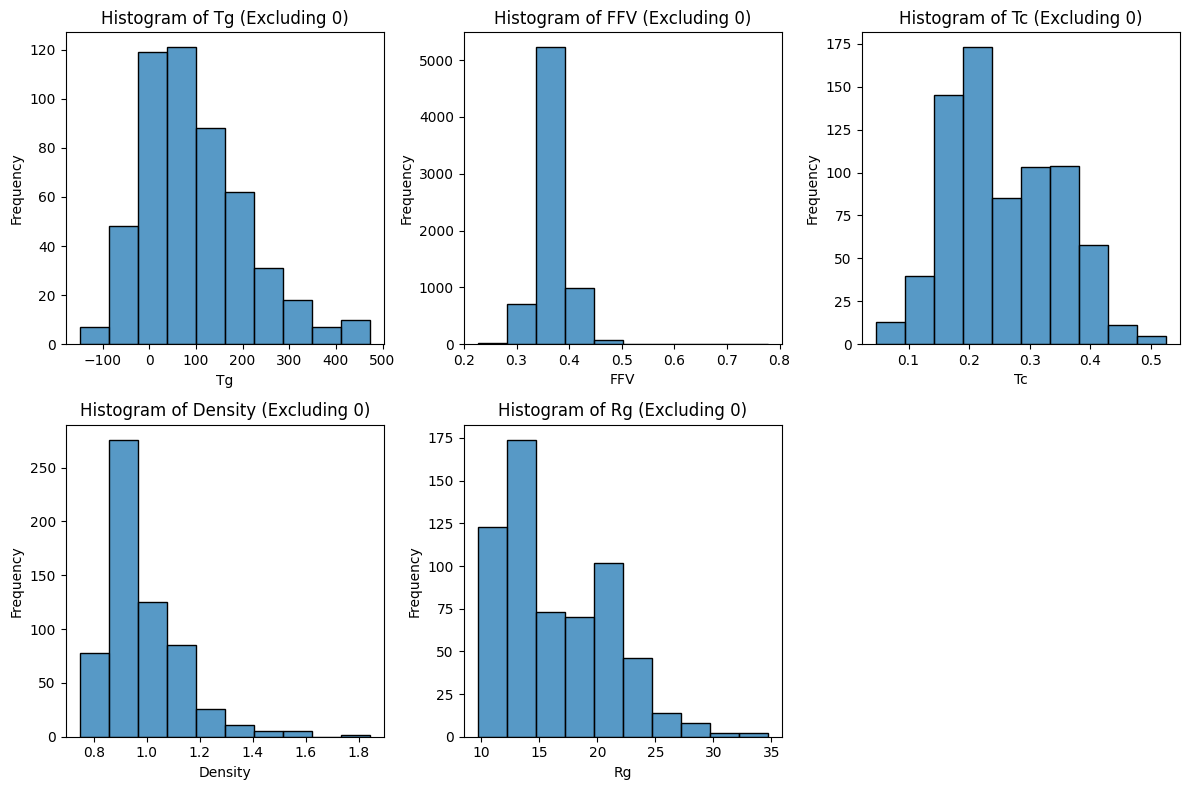

In [7]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(target_colums):
    plt.subplot(2, 3, i + 1)
    sns.histplot(train[train[col] != 0][col], kde=False, bins=10)
    plt.title(f'Histogram of {col} (Excluding 0)')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
train.fillna(0, inplace=True)
target_cols=train.columns.to_list()[2:]
for col in target_cols:
    print( "feature " , col ,"s target row count is :", train[train[col]!=0].shape[0])

feature  Tg s target row count is : 511
feature  FFV s target row count is : 7030
feature  Tc s target row count is : 737
feature  Density s target row count is : 613
feature  Rg s target row count is : 614


In [9]:
dataset1=pd.read_csv(path+"/train_supplement/dataset1.csv")
dataset2=pd.read_csv(path+"/train_supplement/dataset2.csv")
dataset3=pd.read_csv(path+"/train_supplement/dataset3.csv")
dataset4=pd.read_csv(path+"/train_supplement/dataset4.csv")
print("======================= dataset1 is below =======================")
print(dataset1.head(1))
print("======================= dataset2 is below =======================")
print(dataset2.head(1))
print("======================= dataset3 is below =======================")
print(dataset3.head(1))
print("======================= dataset4 is below =======================")
print(dataset4.head(1))

======================= dataset1 is below =======================
                                  SMILES  TC_mean
0  */C(=C(\c1ccccc1)c1ccc(*)cc1)c1ccccc1    0.338
======================= dataset2 is below =======================
                                  SMILES
0  */C(=C(/*)c1ccc(C(C)(C)C)cc1)c1ccccc1
======================= dataset3 is below =======================
                                              SMILES         Tg
0  *=Nc1ccc(N=C(C)Nc2ccc(-c3ccc(NC(=*)C)c(C(=O)O)...  89.380459
======================= dataset4 is below =======================
                                              SMILES       FFV
0  *C(=O)NNC(=O)c1ccc([Si](c2ccccc2)(c2ccccc2)c2c...  0.372725


In [10]:
#SMILESに重複がないことは確認。
dups = train[train['SMILES'].duplicated(keep=False)]
print("training data duplicate count is : ",dups.shape[0])
dups = dataset1[dataset1['SMILES'].duplicated(keep=False)]
print("dataset1 data duplicate count is : ",dups.shape[0])
dups = dataset3[dataset3['SMILES'].duplicated(keep=False)]
print("dataset3 data duplicate count is : ",dups.shape[0])
dups = dataset4[dataset4['SMILES'].duplicated(keep=False)]
print("dataset4 data duplicate count is : ",dups.shape[0])

training data duplicate count is :  0
dataset1 data duplicate count is :  12
dataset3 data duplicate count is :  0
dataset4 data duplicate count is :  0


In [11]:
dataset1.groupby("SMILES").count().sort_values("TC_mean").tail(8)

,TC_mean
SMILES,
*CC(*)CC1CCCC1,1
*CC(*)CC(CC)CC,1
*CC(*)CCC,1
*/C=C/CCC*,2
*/C=C/*,2
*/C=C/CCCCCCCC*,2
*/C=C/CC*,3
*CC/C=C(/*)C,3


In [12]:
dataset1=dataset1.groupby("SMILES").mean().reset_index()

In [13]:
for dataset, col_name in zip([dataset1,dataset3,dataset4],["Tc","Tg","FFV"]):
    print("======================= Check if usable as '",col_name,"' feature =======================")
    same_data_cnt = 0
    different_data_cnt = 0
    differences = []
    additional_data_cnt = 0
    is_target_list=[]
    
    for i in range(dataset.shape[0]):
        if train.loc[train["SMILES"]==dataset.iloc[i,0],col_name].any()==True:
            is_target_list.append(0)
            if train.loc[train["SMILES"]==dataset.iloc[i,0],col_name].values[0] != dataset.iloc[i,1]:
                same_data_cnt+=1
                differences.append( np.abs(train.loc[train["SMILES"]==dataset.iloc[i,0],col_name].values[0] - dataset.iloc[i,1]))
            else:
                different_data_cnt+=1
        else:
            is_target_list.append(1)
            additional_data_cnt+=1
    print("same data count is : ",same_data_cnt)
    print("different data count is :" ,different_data_cnt)
    print("additional data count is :" ,additional_data_cnt)
    
    if different_data_cnt > 0:
        differences_arr = np.array(differences)
        median_val = np.median(differences_arr)
        print("average difference is :",median_val)

    dataset["target"]=is_target_list

    print()

print("======================= dataset1 is below =======================")
print(dataset1.head(2))
print()
print("======================= dataset3 is below =======================")
print(dataset3.head(2))
print()
print("======================= dataset4 is below =======================")
print(dataset4.head(2))

======================= Check if usable as ' Tc ' feature =======================
same data count is :  3
different data count is : 734
additional data count is : 130
average difference is : 0.006222222222222296

======================= Check if usable as ' Tg ' feature =======================
same data count is :  0
different data count is : 0
additional data count is : 46

======================= Check if usable as ' FFV ' feature =======================
same data count is :  0
different data count is : 0
additional data count is : 862

======================= dataset1 is below =======================
                                  SMILES  TC_mean  target
0  */C(=C(\c1ccccc1)c1ccc(*)cc1)c1ccccc1    0.338       1
1     */C(F)=C(\F)C(F)(C(*)(F)F)C(F)(F)F    0.102       0

======================= dataset3 is below =======================
                                              SMILES          Tg  target
0  *=Nc1ccc(N=C(C)Nc2ccc(-c3ccc(NC(=*)C)c(C(=O)O)...   89.380459       1
1 

In [14]:
for row in dataset1[dataset1["target"]==1].iterrows():
    idx = len(train)
    train.loc[idx] = 0
    train.at[idx,"SMILES"]=row[1].SMILES
    train.at[idx,"Tc"]=row[1].TC_mean

for row in dataset3[dataset3["target"]==1].iterrows():
    idx = len(train)
    train.loc[idx] = 0
    train.at[idx,"SMILES"]=row[1].SMILES
    train.at[idx,"Tg"]=row[1].Tg

for row in dataset4[dataset4["target"]==1].iterrows():
    idx = len(train)
    train.loc[idx] = 0
    train.at[idx,"SMILES"]=row[1].SMILES
    train.at[idx,"FFV"]=row[1].FFV

print("training data shape is : ",train.shape)
print("training data duplicate SMILES row num is :" , train[train["SMILES"].duplicated(keep=False)].shape[0])

training data shape is :  (9011, 7)
training data duplicate SMILES row num is : 74


In [15]:
train=train.groupby("SMILES").sum().reset_index()
print("training data shape is : ",train.shape)
print("training data duplicate SMILES row num is :" , train[train["SMILES"].duplicated(keep=False)].shape[0])

training data shape is :  (8974, 7)
training data duplicate SMILES row num is : 0


In [16]:
import itertools
for col1, col2 in itertools.combinations(target_cols, 2):
    # どちらのカラムにも0が含まれない行のみを抽出
    mask = (train[col1] != 0) & (train[col2] != 0)
    subset = train.loc[mask, [col1, col2]]
    
    # サンプル数が十分かチェック（任意）
    n = len(subset)
    if n < 2:
        print(f"{col1} vs {col2}: insufficient data (n={n})")
        continue
    
    # ピアソン相関を計算
    corr = subset[col1].corr(subset[col2])
    print(f"{col1} vs {col2} (n={n}): correlation coefficient = {corr:.3f}")

Tg vs FFV: insufficient data (n=1)
Tg vs Tc (n=32): correlation coefficient = 0.033
Tg vs Density (n=24): correlation coefficient = 0.235
Tg vs Rg (n=24): correlation coefficient = 0.180
FFV vs Tc (n=337): correlation coefficient = 0.148
FFV vs Density (n=270): correlation coefficient = -0.214
FFV vs Rg (n=270): correlation coefficient = 0.053
Tc vs Density (n=531): correlation coefficient = -0.488
Tc vs Rg (n=535): correlation coefficient = 0.555
Density vs Rg (n=610): correlation coefficient = 0.091


In [17]:
def add_smiles_char_counts(df: pd.DataFrame, smiles_col: str = "SMILES") -> pd.DataFrame:
    s = df[smiles_col].fillna("")

    # SMILES でよく出る文字（必要に応じて増減）
    chars = list("CcNnOoSsPpFIBbH[]()=/#\\+-1234567890*@.")
    # ※ バックスラッシュは Python 文字列内でエスケープされるので、'\\' を入れています。

    # 列名に安全な接頭辞を付ける（記号は16進コードで表記）
    def colname_for_char(ch: str) -> str:
        return f"cnt_char_{ch}" if ch.isalnum() else f"cnt_char_0x{ord(ch):02x}"

    feat = pd.DataFrame(index=df.index)
    for ch in chars:
        feat[colname_for_char(ch)] = s.str.count(re.escape(ch))

    return pd.concat([df, feat], axis=1)

def add_smiles_token_counts(df: pd.DataFrame, smiles_col: str = "SMILES") -> pd.DataFrame:
    s = df[smiles_col].fillna("")

    # 代表的 2文字トークン（必要に応じて拡張）
    tokens = ["Cl", "Br", "Si", "Se"]

    feat = pd.DataFrame(index=df.index)
    for tok in tokens:
        feat[f"cnt_tok_{tok}"] = s.str.count(re.escape(tok))

    return pd.concat([df, feat], axis=1)

In [18]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, Crippen

def featurize_smiles(smiles: str):
    import numpy as np
    import pandas as pd

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series(np.nan, index=[
            # 20列分のインデックスをあらかじめ列挙
            "MolWt","NumAromaticRings","NumRings","FractionCSP3",
            "NumRotatableBonds","TPSA","HBA","HBD","BalabanJ","MolLogP",
            "HeavyAtomCount","NumHetero","NumAliphaticRings","NumSaturatedRings"
        ])

    feat = {
        "MolWt": Descriptors.MolWt(mol),
        "NumAromaticRings": Lipinski.NumAromaticRings(mol),
        "NumRings": rdMolDescriptors.CalcNumRings(mol),
        "FractionCSP3": Descriptors.FractionCSP3(mol),
        "NumRotatableBonds": Lipinski.NumRotatableBonds(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBA": Lipinski.NumHAcceptors(mol),
        "HBD": Lipinski.NumHDonors(mol),
        "BalabanJ": Descriptors.BalabanJ(mol),
        "MolLogP": Descriptors.MolLogP(mol),
        "HeavyAtomCount": Lipinski.HeavyAtomCount(mol),
        "NumHetero": Lipinski.NumHeteroatoms(mol),
        "NumAliphaticRings": Lipinski.NumAliphaticRings(mol),
        "NumSaturatedRings": Lipinski.NumSaturatedRings(mol)
    }
    return pd.Series(feat)


features = train["SMILES"].apply(featurize_smiles)
# 元データに結合（列を追加）
df_feat = pd.concat([train, features], axis=1)
df_feat = add_smiles_char_counts(df_feat, smiles_col="SMILES")
df_feat = add_smiles_token_counts(df_feat, smiles_col="SMILES")
df_feat = df_feat.drop("id",axis=1)
print(df_feat.shape)
df_feat

(8974, 62)


,SMILES,Tg,FFV,Tc,Density,Rg,MolWt,NumAromaticRings,NumRings,FractionCSP3,...,cnt_char_8,cnt_char_9,cnt_char_0,cnt_char_0x2a,cnt_char_0x40,cnt_char_0x2e,cnt_tok_Cl,cnt_tok_Br,cnt_tok_Si,cnt_tok_Se
0,*/C(=C(/*)c1ccccc1)c1ccccc1,206.569886,0.0,0.0000,0.000000,0.000000,178.234,2.0,2.0,0.000000,...,0,0,0,2,0,0,0,0,0,0
1,*/C(=C(\c1ccccc1)c1ccc(*)cc1)c1ccccc1,0.000000,0.0,0.3380,0.000000,0.000000,254.332,3.0,3.0,0.000000,...,0,0,0,2,0,0,0,0,0,0
2,*/C(F)=C(\F)C(F)(C(*)(F)F)C(F)(F)F,0.000000,0.0,0.1020,0.000000,0.000000,212.039,0.0,0.0,0.600000,...,0,0,0,2,0,0,0,0,0,0
3,*/C=C(/*)C#CCCCCCCCCCCCCCCCCCCCCC(=O)O,0.000000,0.0,0.4105,0.885737,15.064002,374.609,0.0,0.0,0.800000,...,0,0,0,2,0,0,0,0,0,0
4,*/C=C(/*)CCCCCCCCCCCCCCCCCCCCC(=O)O,0.000000,0.0,0.4030,0.868464,14.078555,350.587,0.0,0.0,0.869565,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,CCNC(=O)OCCCCC(*)=C=C=C(*)CCCCOC(=O)NCC,0.000000,0.0,0.2600,0.000000,0.000000,336.432,0.0,0.0,0.666667,...,0,0,0,2,0,0,0,0,0,0
8970,Cc1ccc(cc1)S(=O)(=O)OCCCCC(*)=C=C=C(*)CCCCOS(=...,0.000000,0.0,0.2100,0.000000,0.000000,502.654,2.0,2.0,0.384615,...,0,0,0,2,0,0,0,0,0,0
8971,FC(F)(F)C(C1=CC2=C(OC(=N2)C2=CC=C(OC3=C4C5C6=C...,0.000000,0.0,0.1090,0.000000,0.000000,996.963,11.0,17.0,0.111111,...,0,0,0,2,0,0,0,0,0,0
8972,FC(F)(F)C(C1=CC2=C(OC(=N2)C2=CC=C(OC3=C4C5C6=C...,0.000000,0.0,0.1760,0.000000,0.000000,820.745,9.0,12.0,0.102041,...,0,0,0,2,0,0,0,0,0,0


In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from lightgbm import early_stopping

TARGETS = ["Tg", "FFV", "Tc", "Density", "Rg"]

# ────────── ユーティリティ ──────────
def feature_cols(df_feat_data, targets=TARGETS):
    print("***")
    num_cols = df_feat_data.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in targets]

def lgb_params_by_n(n_samples, random_state=42):
    """サンプル数で n_estimators・depth をスケール"""
    n_est = int(min(4000, max(300, 22 * np.sqrt(n_samples))))
    depth = -1 if n_samples > 3000 else 6
    return dict(
        n_estimators=n_est,
        learning_rate=0.02,
        num_leaves=2 ** 6,     # depth 6 相当
        max_depth=depth,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="mae",
        random_state=random_state,
        n_jobs=-1,
        verbosity=-1,
    )
# ────────────────────────────────

def train_single_lgbm(
    df_feat: pd.DataFrame,
    target: str,
    feat_cols: list,
    n_splits: int = 5,
    random_state: int = 42,
):
    # --- 0 を除外 ---
    data = df_feat.loc[df_feat[target].notna() & (df_feat[target] != 0)].copy()
    X = data[feat_cols].values
    y = data[target].values
    n = len(y)
    if n < 2:
        raise ValueError(f"{target}: 有効サンプル不足 (n={n})")

    params = lgb_params_by_n(n, random_state)
    kf = KFold(n_splits=max(2, min(n_splits, n)), shuffle=True, random_state=random_state)

    oof = np.full(n, np.nan)
    fold_mae = []

    for tr_idx, va_idx in kf.split(X):
        model = LGBMRegressor(**params)
        model.fit(
            X[tr_idx], y[tr_idx],
            eval_set=[(X[va_idx], y[va_idx])],
            eval_metric="l1",
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False)
            ],
        )
        pred = model.predict(X[va_idx])
        oof[va_idx] = pred
        fold_mae.append(mean_absolute_error(y[va_idx], pred))

    cv_mae = float(np.mean(fold_mae))

    # --- フルデータ学習 ---
    final_model = LGBMRegressor(**params)
    final_model.fit(X, y)

    return {
        "target": target,
        "model": final_model,
        "cv_mae": cv_mae,
        "n_train": n,
        "oof_pred": oof,
    }

def train_all_lgbm(df_feat: pd.DataFrame, targets=TARGETS, n_splits=5, random_state=42):
    print(targets)
    feats = feature_cols(df_feat, targets)
    results = {}
    for t in targets:
        res = train_single_lgbm(df_feat, t, feats, n_splits, random_state)
        results[t] = res
        print(f"{t}: CV MAE={res['cv_mae']:.5f}  n={res['n_train']}")
    return results, feats

def predict_all_lgbm(results: dict, df_feat: pd.DataFrame, feat_cols: list):
    X = df_feat[feat_cols].values
    return pd.DataFrame({t: res["model"].predict(X) for t, res in results.items()},
                        index=df_feat.index)

In [20]:
def wmae(y_true: pd.DataFrame,
         y_pred: pd.DataFrame,
         weights: dict) -> float:
    """
    各ターゲット列に重みを付けた MAE を計算（NaN を無視）。
    weights: {"Tg":0.2, "FFV":0.2, ...} のような辞書
    """
    props = list(weights.keys())
    w = pd.Series(weights, dtype=float)

    # 絶対誤差
    err = (y_pred[props] - y_true[props]).abs()

    # 列ごとに重み付け
    weighted_err = err.mul(w, axis=1)

    # 行ごとの「有効重み合計」（= NaN でない列だけを合計）
    effective_w = (~err.isna()).mul(w, axis=1).sum(axis=1)

    # 行ごとの wMAE → 全行平均
    row_wmae = weighted_err.sum(axis=1) / effective_w
    return float(row_wmae.mean())


def overall_wmae_with_zero_ignored(y_true_df: pd.DataFrame,
                                   y_pred_df: pd.DataFrame,
                                   weights: dict) -> float:
    """
    真値が 0 のセルを NaN に置換してから wMAE を計算。
    """
    y_true_masked = y_true_df.copy()
    for col in weights.keys():
        if col in y_true_masked.columns:
            y_true_masked.loc[y_true_masked[col] == 0, col] = np.nan
    return wmae(y_true_masked, y_pred_df, weights)

In [21]:
results, feature_cols_list = train_all_lgbm(df_feat)

pred_train = predict_all_lgbm(results, df_feat, feature_cols_list)

# overall wMAE は以前の wmae / overall_wmae_with_zero_ignored をそのまま使用
weights = {"Tg":0.2,"FFV":0.2,"Tc":0.2,"Density":0.2,"Rg":0.2}
overall = overall_wmae_with_zero_ignored(df_feat[TARGETS], pred_train[TARGETS], weights)
print("Overall wMAE:", overall)

['Tg', 'FFV', 'Tc', 'Density', 'Rg']
***
Tg: CV MAE=52.13204  n=557
FFV: CV MAE=0.00715  n=7892
Tc: CV MAE=0.03343  n=867
Density: CV MAE=0.03909  n=613
Rg: CV MAE=2.22438  n=614
Overall wMAE: 1.7317131347031927


In [22]:
# ---- 重要度 DataFrame を取得（単一ターゲット） ----
def lgb_importance_df(results, feature_cols_list, target, importance_type="gain"):
    model = results[target]["model"]
    if importance_type == "gain":
        imp = model.booster_.feature_importance(importance_type="gain")
    else:  # "split"（分割回数）
        imp = model.feature_importances_
    df = pd.DataFrame({"feature": feature_cols_list, "importance": imp})
    return df.sort_values("importance", ascending=False)

# ---- 上位k件を図示（単一ターゲット） ----
def plot_topk_importance(results, feature_cols_list, target, k=10, importance_type="gain"):
    imp_df = lgb_importance_df(results, feature_cols_list, target, importance_type)
    top = imp_df.head(k).iloc[::-1]  # barh用に逆順
    plt.figure(figsize=(10, max(5, 0.35 * len(top))))
    plt.barh(top["feature"], top["importance"])
    plt.xlabel(f"Importance ({importance_type})")
    plt.title(f"{target} - Top {min(k, len(imp_df))} LightGBM feature importances")
    plt.tight_layout()
    plt.show()


def plot_topbottomk_importance_mean(results, feature_cols_list, k,
                                 importance_type="gain", normalize=True,
                                 drop_all_zero=False):
    targets = list(results.keys())
    M = pd.DataFrame(0.0, index=feature_cols_list, columns=targets)

    for t in targets:
        model = results[t]["model"]
        if importance_type == "gain":
            imp = model.booster_.feature_importance(importance_type="gain")
        else:  # "split"
            imp = model.feature_importances_
        imp = np.asarray(imp, dtype=float)
        if normalize and imp.sum() > 0:
            imp = imp / imp.sum()
        M[t] = imp

    mean_imp = M.mean(axis=1)

    # if drop_all_zero:
    #     mean_imp = mean_imp[mean_imp > 0]  # 全ターゲットで一度も使われてない列を除外

    # 下位k件（小さい順に並べ、見やすいよう逆順でプロット）
    top = mean_imp.sort_values(ascending=False).head(k)[::-1]
    bottom = mean_imp.sort_values(ascending=True).head(k)[::-1]

    plt.figure(figsize=(10, max(5, 0.35 * len(top))))
    plt.barh(top.index, top.values)
    plt.xlabel("Mean importance" + (" (normalized per target)" if normalize else ""))
    plt.title(f"Average Top{min(k, len(mean_imp))} LightGBM feature importances")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, max(5, 0.35 * len(bottom))))
    plt.barh(bottom.index, bottom.values)
    plt.xlabel("Mean importance" + (" (normalized per target)" if normalize else ""))
    plt.title(f"Average Bottom {min(k, len(mean_imp))} LightGBM feature importances")
    plt.tight_layout()
    plt.show()

    return bottom.index,top.index


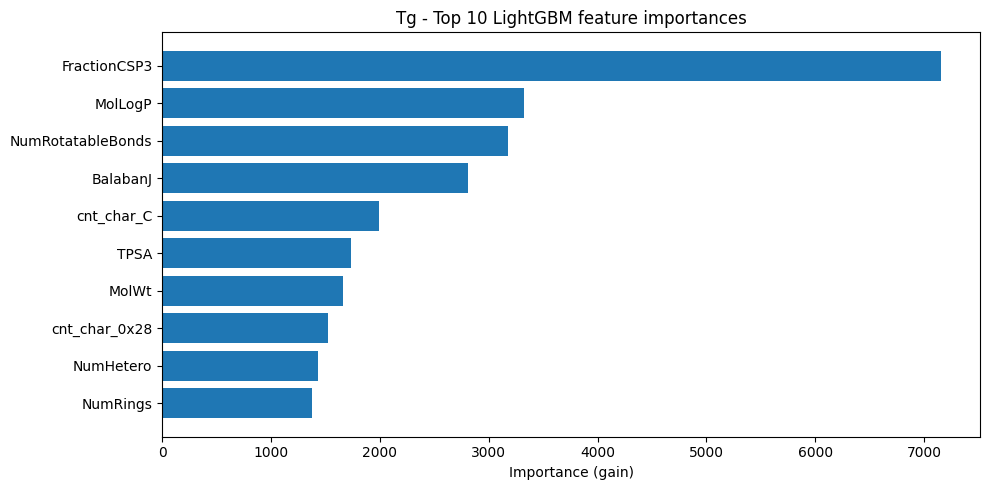

In [23]:
plot_topk_importance(results, feature_cols_list, target="Tg", k=10, importance_type="gain")

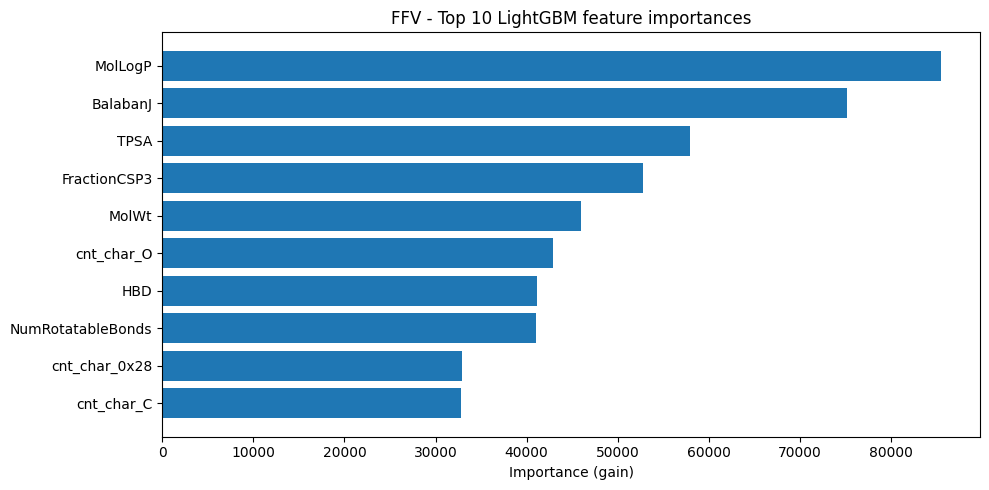

In [24]:
plot_topk_importance(results, feature_cols_list, target="FFV", k=10, importance_type="gain")

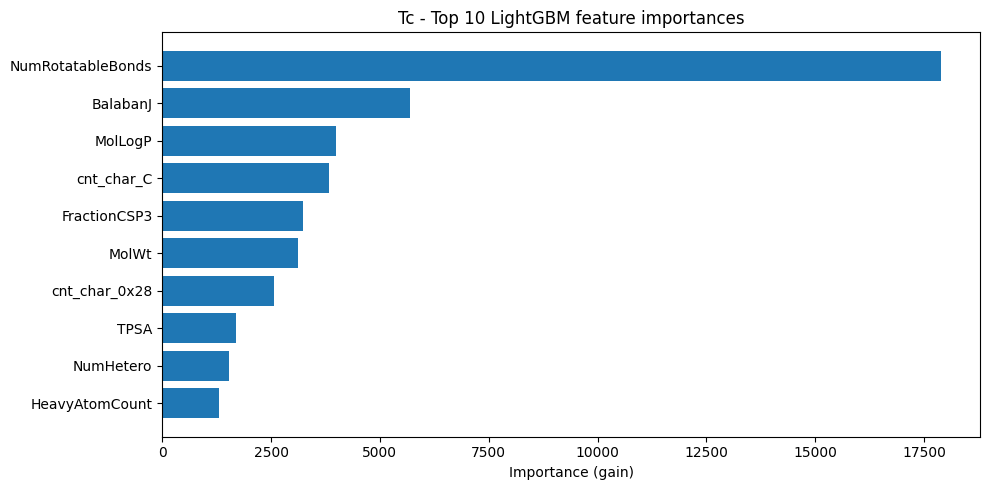

In [25]:
plot_topk_importance(results, feature_cols_list, target="Tc", k=10, importance_type="gain")

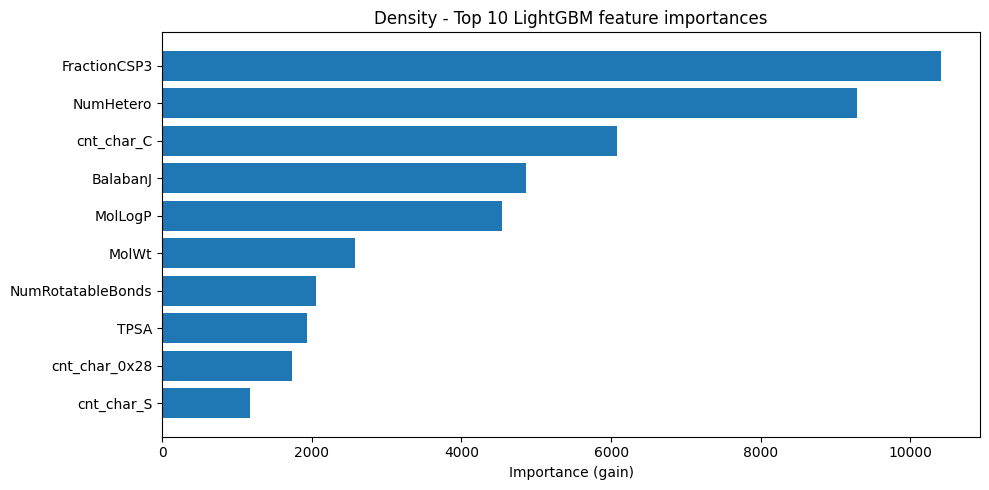

In [26]:
plot_topk_importance(results, feature_cols_list, target="Density", k=10, importance_type="gain")

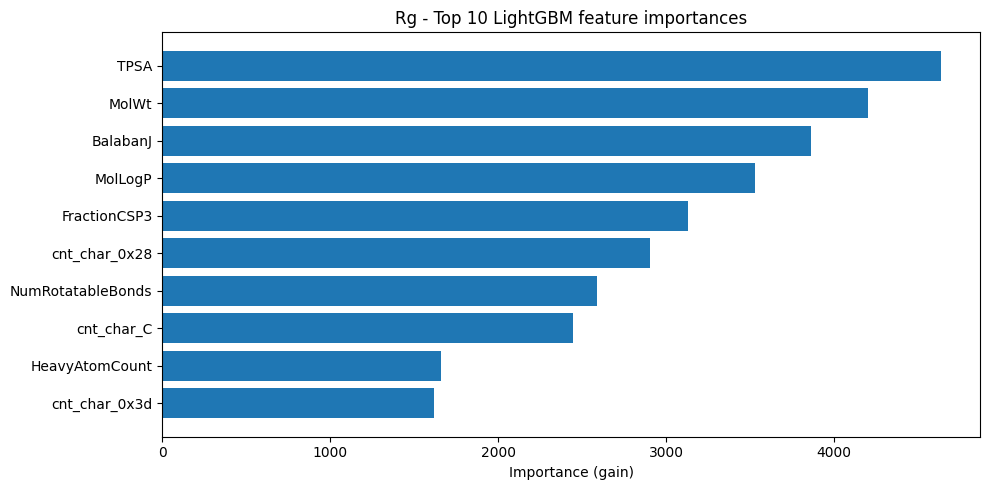

In [27]:
# ターゲット別（例：Tg）の上位30件
plot_topk_importance(results, feature_cols_list, target="Rg", k=10, importance_type="gain")

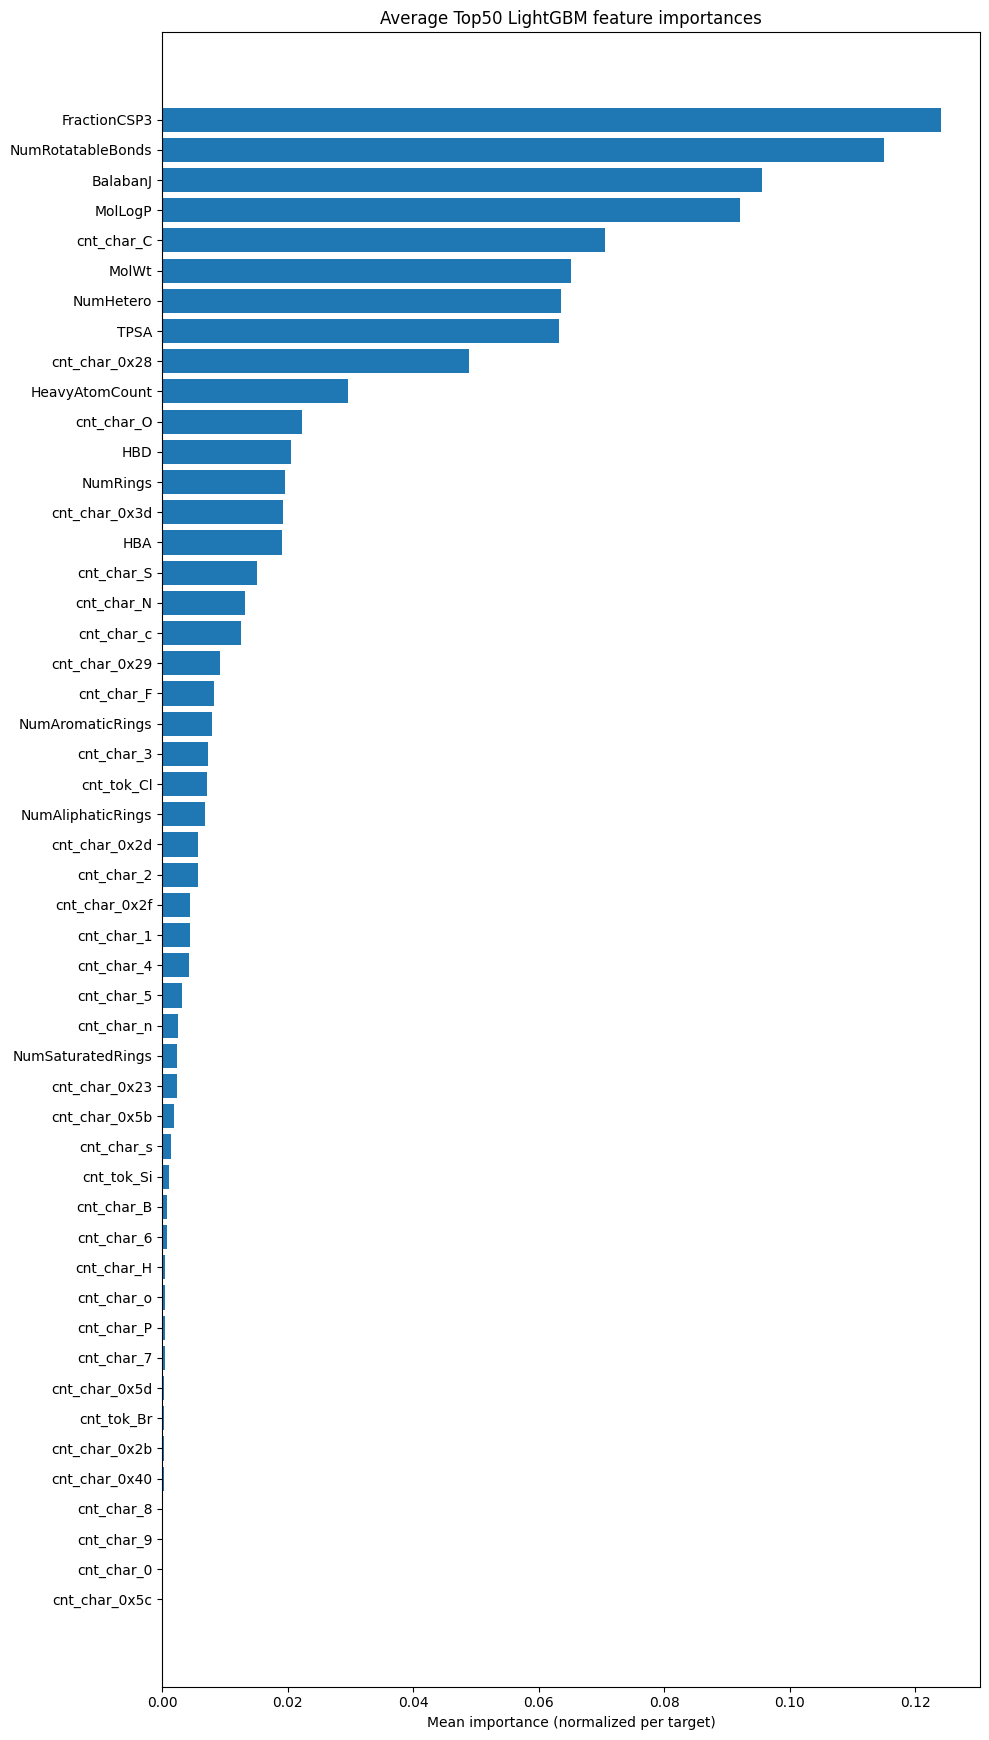

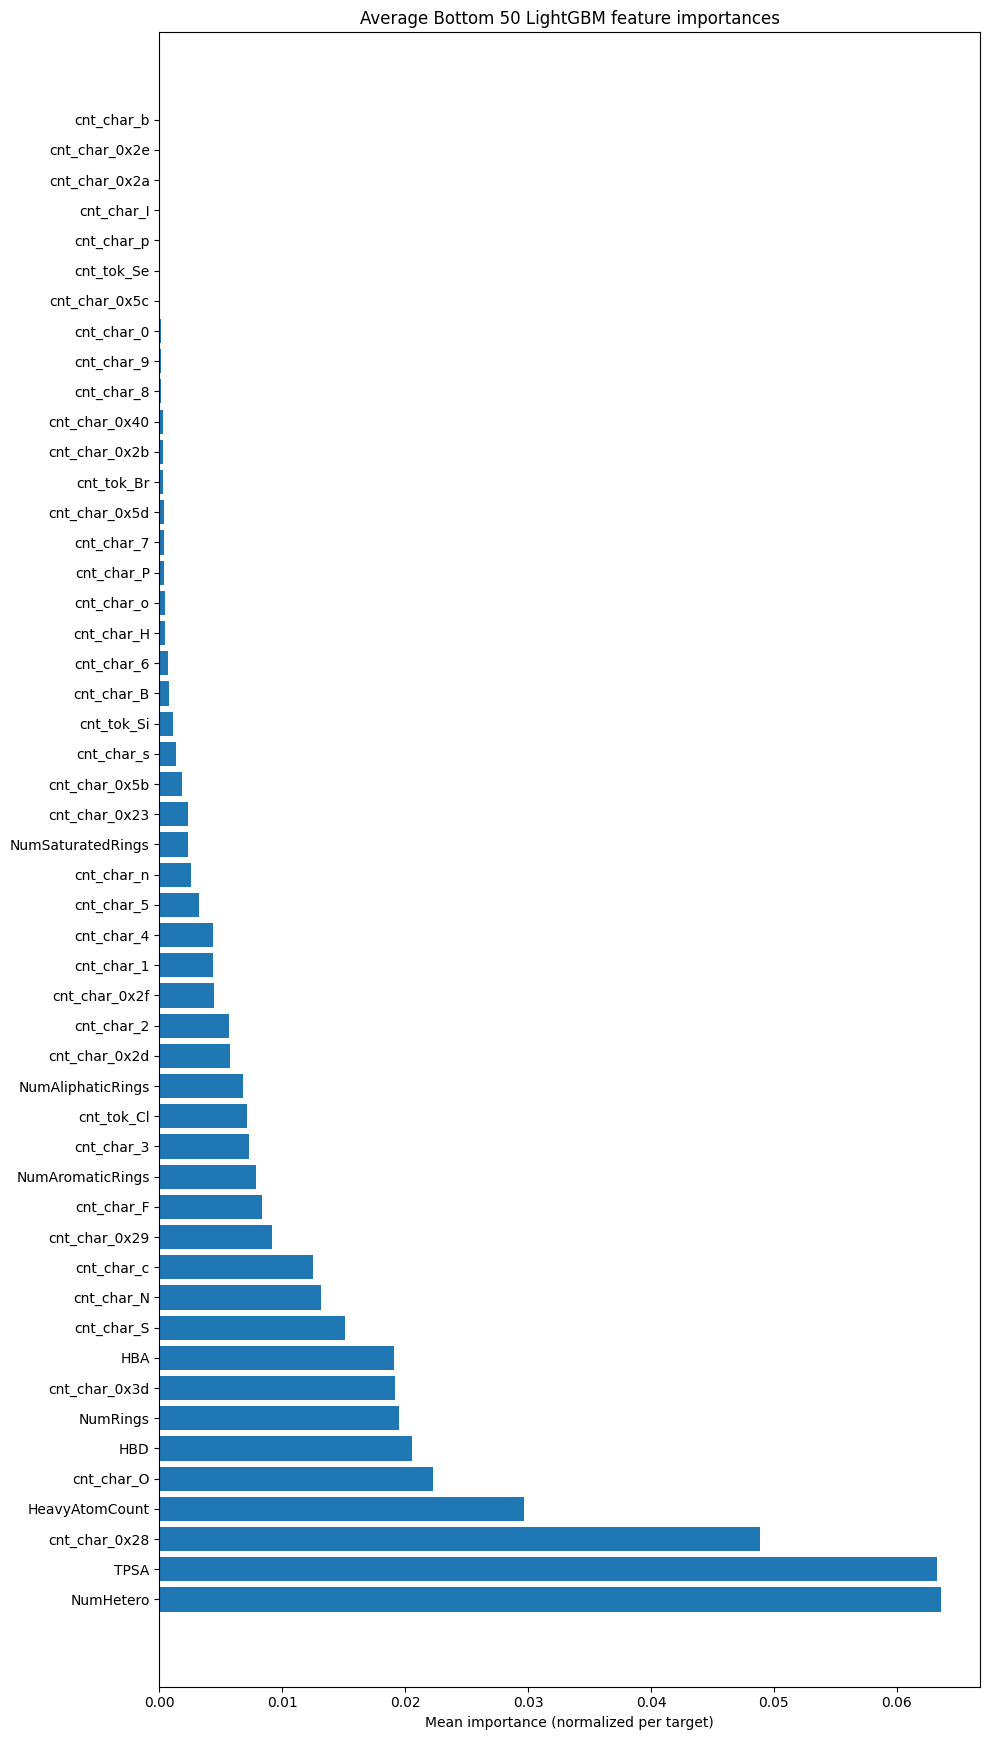

In [28]:
plot_bottomk_importance_list,plot_top_importance_list = plot_topbottomk_importance_mean(results, feature_cols_list, k=50,
                             importance_type="gain", normalize=True,
                             drop_all_zero=True)

In [29]:
df_feat = pd.concat([train, features], axis=1)
df_feat = add_smiles_char_counts(df_feat, smiles_col="SMILES")
df_feat = add_smiles_token_counts(df_feat, smiles_col="SMILES")
df_feat = df_feat.drop("id",axis=1)
df_feat = df_feat.drop(plot_bottomk_importance_list.tolist(),axis=1)
print(df_feat.shape)
results, feature_cols_list  = train_all_lgbm(df_feat)

pred_train = predict_all_lgbm(results, df_feat, feature_cols_list )

# overall wMAE は以前の wmae / overall_wmae_with_zero_ignored をそのまま使用
weights = {"Tg":0.2,"FFV":0.2,"Tc":0.2,"Density":0.2,"Rg":0.2}
overall = overall_wmae_with_zero_ignored(df_feat[TARGETS], pred_train[TARGETS], weights)
print("Overall wMAE:", overall)

(8974, 12)
['Tg', 'FFV', 'Tc', 'Density', 'Rg']
***
Tg: CV MAE=56.69381  n=557
FFV: CV MAE=0.01187  n=7892
Tc: CV MAE=0.03695  n=867
Density: CV MAE=0.05521  n=613
Rg: CV MAE=2.45338  n=614
Overall wMAE: 2.1190914954893314


In [30]:
df_feat = pd.concat([train, features], axis=1)
df_feat = add_smiles_char_counts(df_feat, smiles_col="SMILES")
df_feat = add_smiles_token_counts(df_feat, smiles_col="SMILES")
df_feat = df_feat[plot_top_importance_list.tolist()+TARGETS]
print(df_feat.shape)
results, feature_cols_list  = train_all_lgbm(df_feat)

pred_train = predict_all_lgbm(results, df_feat, feature_cols_list )

# overall wMAE は以前の wmae / overall_wmae_with_zero_ignored をそのまま使用
weights = {"Tg":0.2,"FFV":0.2,"Tc":0.2,"Density":0.2,"Rg":0.2}
overall = overall_wmae_with_zero_ignored(df_feat[TARGETS], pred_train[TARGETS], weights)
print("Overall wMAE:", overall)

(8974, 55)
['Tg', 'FFV', 'Tc', 'Density', 'Rg']
***
Tg: CV MAE=52.25473  n=557
FFV: CV MAE=0.00712  n=7892
Tc: CV MAE=0.03340  n=867
Density: CV MAE=0.03950  n=613
Rg: CV MAE=2.22222  n=614
Overall wMAE: 1.7505665342656958


In [31]:
test_df = pd.read_csv(path+"test.csv")
test_df

,id,SMILES
0,1109053969,*Oc1ccc(C=NN=Cc2ccc(Oc3ccc(C(c4ccc(*)cc4)(C(F)...
1,1422188626,*Oc1ccc(C(C)(C)c2ccc(Oc3ccc(C(=O)c4cccc(C(=O)c...
2,2032016830,*c1cccc(OCCCCCCCCOc2cccc(N3C(=O)c4ccc(-c5cccc6...


In [32]:
submit_df = pd.read_csv(path+"sample_submission.csv")
submit_df

,id,Tg,FFV,Tc,Density,Rg
0,1109053969,0,0,0,0,0
1,1422188626,0,0,0,0,0
2,2032016830,0,0,0,0,0


In [33]:
"""前提
featurize_smiles() ― 学習時と同じ特徴量生成関数
results     ― 単一タスク学習後のモデル辞書
feature_cols   ― 学習時に抽出した数値特徴名リスト
TARGETS = ["Tg", "FFV", "Tc", "Density", "Rg"]"""

# --- 1. SMILES → 特徴量に展開 ---
feat_test = test_df["SMILES"].apply(featurize_smiles)
test_feat = pd.concat([test_df, feat_test], axis=1)
test_feat = add_smiles_char_counts(test_feat, smiles_col="SMILES")
test_feat = add_smiles_token_counts(test_feat, smiles_col="SMILES")
test_feat = test_feat[plot_top_importance_list.tolist()]

# --- 2. 学習時に存在した特徴列を保証（欠けていれば 0を追加） ---
for col in feature_cols_list:
    if col not in test_feat.columns:
        test_feat[col] = 0

# --- 3. 推論 ---
preds = predict_all_lgbm(results, test_feat , feature_cols_list)   # DataFrame (len(test) × 5)

# --- 4. submission の TARGET カラムを上書き ---
submit_df.loc[:, TARGETS] = preds[TARGETS].values

# --- 5. 必要なら CSV 保存 ---
submit_df.to_csv("submission.csv", index=False)

submit_df


,id,Tg,FFV,Tc,Density,Rg
0,1109053969,149.355615,0.372697,0.191032,1.215417,18.725281
1,1422188626,142.795688,0.375943,0.230748,1.073527,21.009652
2,2032016830,67.260998,0.350313,0.257720,1.110242,20.218129
